In [ ]:
!pip install autogluon.tabular dalex

# Import Libraries

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

import dalex as dx # for explanations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# Load German Credit
----
The German Credit Data is a popular dataset used for credit scoring and financial analysis. The dataset comprises attributes of individuals who have taken credit/loans from a financial institution and includes various features that could influence an individual's credit risk.

### Key Characteristics

- **Size and Scope:** The dataset typically includes data on 1000 loan applicants.
- **Features:** It contains a mix of attributes, including both numerical and categorical data. Features may encompass age, sex, job, credit history, purpose of the loan (e.g., car loan, home loan), amount of credit, savings account/bonds, present employment since, installment rate in percentage of disposable income, personal status and sex, other debtors/guarantors, present residence since, property, age, other installment plans, housing, number of existing credits at this bank, job, number of people being liable to provide maintenance for, telephone, foreign worker status, and more.
- **Target Variable:** The primary outcome variable is a binary attribute indicating whether the credit risk is considered good or bad.


### Challenges and Considerations

- **Bias and Fairness:** When working with the German Credit Data, it's important to consider potential biases inherent in the data, especially related to demographic attributes like age, sex, and job.
- **Data Privacy:** While the dataset is publicly available, it serves as a reminder of the importance of respecting data privacy and ethical considerations in data science projects, especially when dealing with sensitive financial information.


In [ ]:
# credit data
data = dx.datasets.load_german()

# risk is the target
X = data.drop(columns='risk')
y = data.risk

# Split the dataset into train and test
train_data, test_data,  = train_test_split(data, test_size=0.3, random_state=42)
print(f"X_train: {train_data.shape}")
print(f"X_test: {test_data.shape}")

X_train: (700, 10)
X_test: (300, 10)


In [ ]:
X.dtypes

,0
sex,object
job,int64
housing,object
saving_accounts,object
checking_account,object
credit_amount,int64
duration,int64
purpose,object
age,int64


## Train an AutoGluon Model

AutoGluon is an open-source AutoML (Automated Machine Learning) library designed to simplify the process of applying machine learning to real-world problems. Developed by AWS (Amazon Web Services), it enables developers and data scientists to achieve high-quality machine learning models with minimal effort and expertise in machine learning. AutoGluon automates the tasks of applying machine learning, such as feature preprocessing, model selection, hyperparameter tuning, ensembling, and prediction, making it accessible to both novices and experts in the field.

### Key Features

- **Ease of Use:** AutoGluon allows for the training of high-quality machine learning models with just a few lines of code. It is designed to be user-friendly, requiring minimal input from the user to get started with machine learning tasks.

- **Multi-Model Training:** It automatically trains and tunes many models in parallel and combines them into an ensemble that often outperforms the individual models.

- **Versatility:** AutoGluon is versatile and can be applied to various types of data and prediction tasks, including classification, regression, and forecasting problems. It supports tabular data, image data, and text data, making it suitable for a wide range of applications.

- **Customization and Control:**  It also offers options for customization and control over the modeling process, allowing more experienced users to tweak the models to their specific needs.






In [ ]:
time_limit = 180           # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'f1'              # specify your evaluation metric here


canidate_models = {
    'XGB': {},  # Use default hyperparameters for XGBoost
    'GBM': {},  # Use default hyperparameters for GradientBoosting
    'RF': {},  # Specify hyperparameters for Random Forest
    # Exclude models by not listing them, e.g., 'XGB', 'NN', and 'KNN' are not listed and thus excluded
}


# Initialize the TabularPredictor object.
glu_model = TabularPredictor(label='risk',
                             problem_type='binary',
                             eval_metric=metric)


# Fit the model.
"""
presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
"""
glu_model = glu_model.fit(train_data,
                          time_limit=time_limit,
                          hyperparameters=canidate_models,
                          presets='medium_quality', # switch to one of the above presets.
                          )

No path specified. Models will be saved in: "AutogluonModels/ag-20240801_202341"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.39 GB / 12.67 GB (81.9%)
Disk Space Avail:   198.41 GB / 225.83 GB (87.9%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "AutogluonModels/ag-20240801_202341"
Train Data Rows:    700
Train Data Columns: 9
Label Column:       risk
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10635.17 MB
	Train Data (Original)  Memory Usage: 0.23 MB (0.0% of

## Model Performance

In [ ]:
# training
glu_model.evaluate(train_data)

{'f1': 0.9593657086223984,
 'accuracy': 0.9414285714285714,
 'balanced_accuracy': 0.9115319775090382,
 'mcc': 0.8587107465362352,
 'roc_auc': 0.9597637864333116,
 'precision': 0.9343629343629344,
 'recall': 0.9857433808553971}

In [ ]:
# test set
glu_model.evaluate(test_data)

{'f1': 0.834782608695652,
 'accuracy': 0.7466666666666667,
 'balanced_accuracy': 0.6351543193648457,
 'mcc': 0.3361389691701807,
 'roc_auc': 0.7516168042483832,
 'precision': 0.7649402390438247,
 'recall': 0.9186602870813397}

In [ ]:
glu_model.leaderboard(test_data, extra_metrics=['roc_auc','accuracy','precision', 'recall'])


,model,score_test,roc_auc,accuracy,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.836207,0.760871,0.746667,0.760784,0.928230,0.857143,f1,0.042263,0.006528,2.318377,0.042263,0.006528,2.318377,1,True,1
1,XGBoost,0.834783,0.751617,0.746667,0.764940,0.918660,0.865116,f1,0.161594,0.038208,6.247422,0.161594,0.038208,6.247422,1,True,3
2,WeightedEnsemble_L2,0.834783,0.751617,0.746667,0.764940,0.918660,0.865116,f1,0.178447,0.061086,6.852688,0.016853,0.022878,0.605266,2,True,4
3,RandomForest,0.826667,0.747673,0.740000,0.771784,0.889952,0.829493,f1,0.294247,0.212054,1.976632,0.294247,0.212054,1.976632,1,True,2


In [ ]:
# variable importance
permutation_importance = glu_model.feature_importance(test_data.sample(100)).reset_index()
permutation_importance

Computing feature importance via permutation shuffling for 9 features using 100 rows with 5 shuffle sets...
	8.56s	= Expected runtime (1.71s per shuffle set)
	1.0s	= Actual runtime (Completed 5 of 5 shuffle sets)


,index,importance,stddev,p_value,n,p99_high,p99_low
0,checking_account,0.025016,0.017859,0.017557,5,0.061788,-0.011757
1,duration,0.013891,0.027340,0.159674,5,0.070185,-0.042402
2,job,0.010256,0.007005,0.015340,5,0.024680,-0.004167
3,credit_amount,0.004509,0.012087,0.225548,5,0.029397,-0.020379
4,age,0.003467,0.012377,0.282519,5,0.028951,-0.022017
5,housing,-0.001237,0.003670,0.753536,5,0.006319,-0.008793
6,purpose,-0.001244,0.011948,0.586363,5,0.023356,-0.025845
7,sex,-0.009322,0.002332,0.999567,5,-0.004520,-0.014123
8,saving_accounts,-0.011694,0.003623,0.999022,5,-0.004233,-0.019154


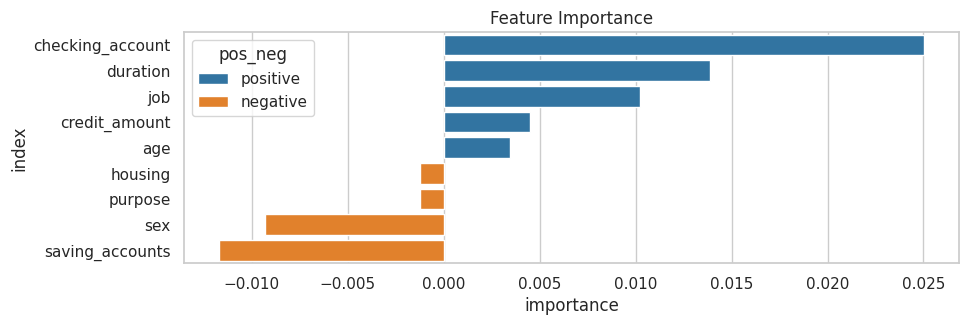

In [ ]:
permutation_importance['pos_neg'] = np.where(permutation_importance['importance']< 0 , 'negative', 'positive')
#permutation_importance['importance'] = permutation_importance['importance'].abs()

plt.figure(figsize=(10, 3))
sns.barplot(x='importance', y='index', data=permutation_importance, hue='pos_neg')
plt.title('Feature Importance')
plt.show()

# Partial Dependence Plots
---


Partial Dependence Plots (PDPs) are a  tool for interpreting the behavior of machine learning models. Unlike most other interpretability methods, PDPs offer a graphical representation of the **average effect** that features have on the predicted outcome of a model, **holding all other features constant**. PDPs are used to understand complex interactions between features and predictions.

## Why Partial Dependence Plots?

In the realm of machine learning, where models often become black boxes, understanding how input variables affect the prediction is important. PDPs shine by providing insights into the model in a way that is both comprehensive and accessible. They help in:

- **Identifying Feature Importance:** By visualizing how changes in feature values affect the model's predictions, we can understand which features have the most significant impact.
- **Understanding Non-Linear Relationships:** PDPs can reveal complex, non-linear relationships between features and the target variable that might be missed by other analysis methods.


## Sampling in Partial Dependence Plots

When working with large datasets, generating a PDP are  computationally expensive, as it requires recalculating predictions for many combinations of feature values and data points. Sampling is a practical approach to mitigate this issue:

- **Efficiency:** Sampling a subset of the data to generate PDPs can significantly reduce computational time and resources, making it a viable strategy for preliminary analysis or when working with very large datasets.
- **Effectiveness:** Despite using a sample, the plots often provide a good **approximation of the partial dependence across** the entire dataset, especially if the sample is representative.


> the GOAL:
the goal of using PDPs is to improve model transparency and also to gain deeper insights into the data and the modeled relationships.

The following two functions are used to analyze numeric and categorical data.


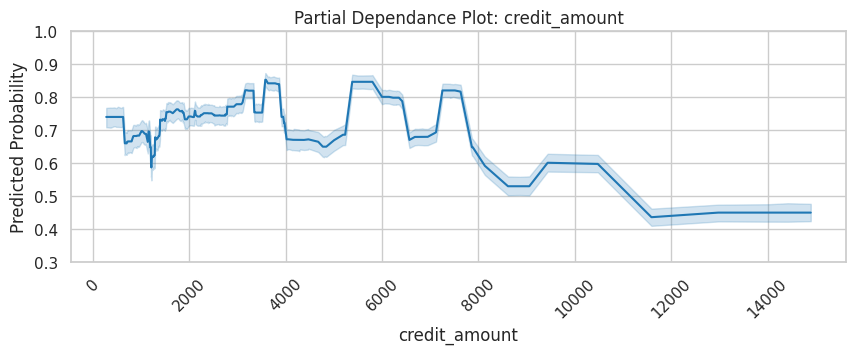

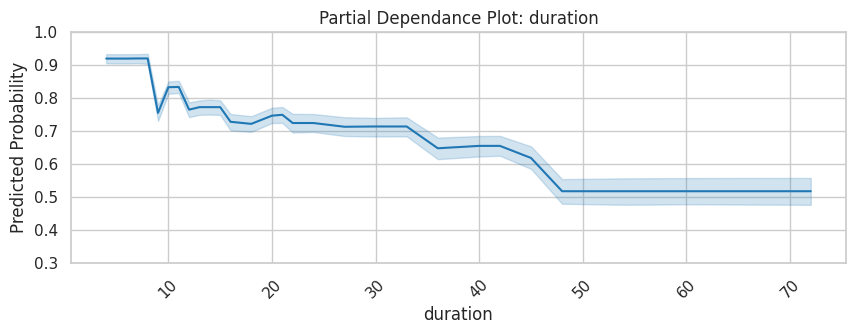

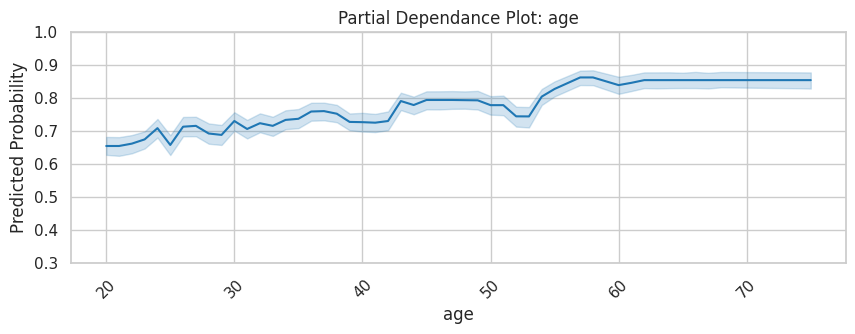

In [ ]:
def pdp_plot_numeric(var, sample_n):
  # var = 'credit_amount'
  pdp_values = pd.DataFrame(test_data[var].sort_values().unique(),columns=[var])
  pdp_sample = test_data.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = glu_model.predict_proba(pdp_cross)[1]
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  plt.ylim(0.3, 1)
  plt.grid(True)
  plt.show()

numeric_features = ['credit_amount', 'duration', 'age']
for var in numeric_features:
  pdp_plot_numeric(var, sample_n=300)

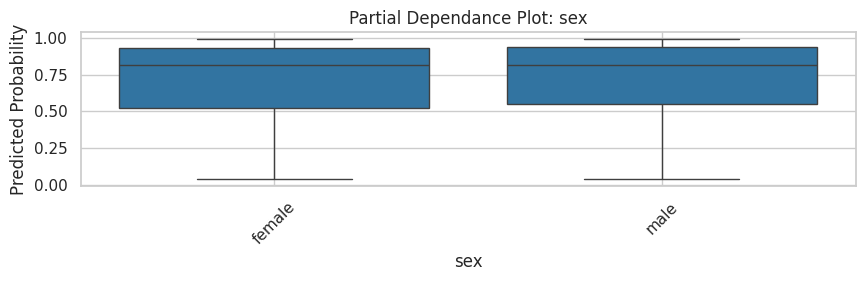

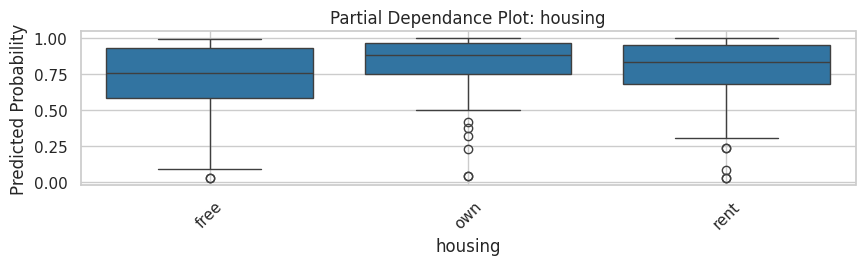

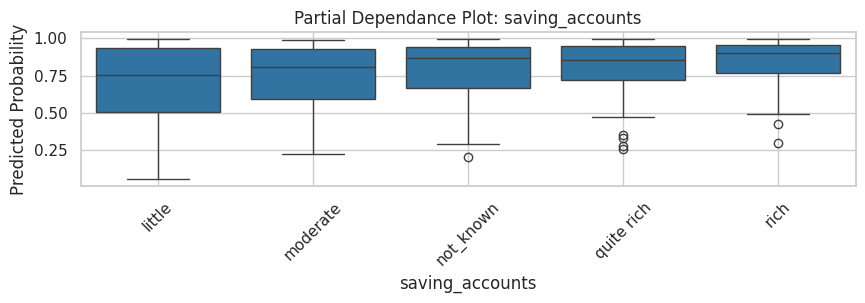

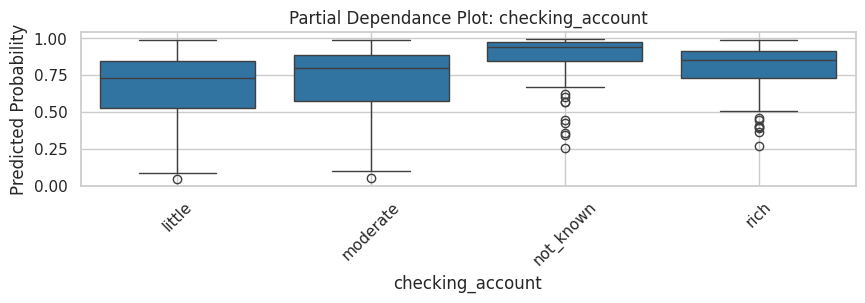

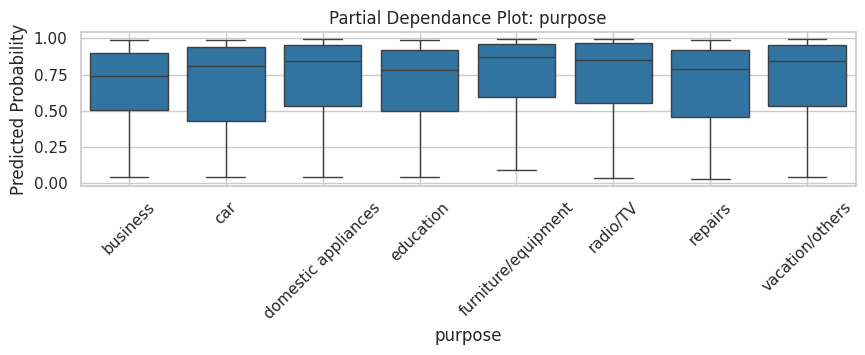

In [ ]:
def pdp_plot_categorical(var, sample_n):
  sns.set_style("whitegrid")  # Try "darkgrid", "ticks", etc.
  sns.set_context("notebook")  # Try "paper", "notebook", "poster" for different sizes

  pdp_values = pd.DataFrame(test_data[var].sort_values().unique(),columns=[var])
  pdp_sample = test_data.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = glu_model.predict_proba(pdp_cross)[1]
  plt.figure(figsize=(10, 2))
  #sns.pointplot(x='Category', y='PredictedOutcome', data=pdp_categorical, join=False)

  sns.boxplot(x=f"{var}", y='pred', data=pdp_cross,
                #linestyle='--',
                #capsize=.01,  # Adjust the width of the caps
              #errorbar='sd')
  )
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()


categorical_features = test_data.select_dtypes("object")
for var in categorical_features:
  pdp_plot_categorical(var, sample_n=100)

# DALEX Explainer
----



In [ ]:
def predict_function(model, data):
    return model.predict(data).values

def predict_proba_function(model, data):
    return model.predict_proba(data)[1].to_numpy()


rec = data.iloc[1].to_frame().T
predict_function(glu_model, rec)
predict_proba_function(glu_model, rec)

array([0.08054747])

# DALEX
---
DALEX (Descriptive mAchine Learning EXplanations) is a framework designed to offer a set of tools and methods for understanding and explaining the behavior and predictions of machine learning models.

Developed with the goal of making complex models more transparent and interpretable, DALEX provides a model-agnostic approach, meaning it can be applied to any type of model, from simple linear models to complex ensemble and deep learning models. This universality makes it an invaluable tool for data scientists and analysts looking to provide insights into model decisions, ensure compliance with regulatory demands, and improve model understanding and trust among users.

### Key Features of DALEX

- **Model Agnosticism:** DALEX can work with any model, regardless of its complexity or the algorithm it was built with, facilitating a wide range of applications.
- **Unified Interface:** It provides a consistent set of tools and methods for model explanation, making it easier to compare the behavior and predictions of different models.
- **Comprehensive Explanations:** DALEX offers explanations for both global model behavior and local predictions, including feature importance, feature contribution, and prediction decomposition.

### Core Components of DALEX Explanations

1. **Explainer:** The central element of DALEX, an Explainer is created from a model and data. It serves as the basis for generating various explanations, effectively encapsulating the model and making it interpretable.

2. **Global Explanations:** These help in understanding the overall behavior of the model. Techniques like variable importance plots show which features have the most impact on model predictions across the entire dataset.

3. **Local Explanations:** Focus on individual predictions, offering insights into why the model made a specific decision for a single instance. This includes tools like Break Down or SHAP values, which decompose a prediction to show the contribution of each feature.

4. **Model Diagnostics:** DALEX also provides functionalities for assessing and comparing model performance through various diagnostic plots and measures, aiding in model evaluation and selection.

### Getting Started with DALEX


- Install the `dalex` package.
- Create an Explainer object with your model and data.
- Use the Explainer to generate various explanations and diagnostics.


Step 1 : Create Explainer
Step 2 : Generate Model Summary
Step 3 : Generate Model Variable Importance
Step 4 : Model


In [ ]:
# note need to split into X and y
X_test = test_data.drop('risk', axis=1)
y_test = test_data['risk']


glu_explainer = dx.Explainer(glu_model, X_test, y_test.values,
                           predict_function=predict_function, label='loan_default')

Preparation of a new explainer is initiated

  -> data              : 300 rows 9 cols
  -> target variable   : 300 values
  -> model_class       : autogluon.tabular.predictor.predictor.TabularPredictor (default)
  -> label             : loan_default
  -> predict function  : <function predict_function at 0x7bcd281ffe20> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.837, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.14, max = 1.0
  -> model_info        : package autogluon

A new explainer has been created!


In [ ]:
mp_default = glu_explainer.model_performance("classification")
mp_default.result

,recall,precision,f1,accuracy,auc
loan_default,0.91866,0.76494,0.834783,0.746667,0.635154


In [ ]:
# Calculate feature importance
fi = glu_explainer.model_parts()

# Plot feature importance
fi.plot()

## Partial Dependance PLOTS (PDP)
---
deal with numerics first!  

In [ ]:
# Let's say you want to create PDPs for a feature named 'feature_name'
profile = glu_explainer.model_profile(variables=['duration', 'credit_amount', 'age'])

# Now, plot the PDP for 'feature_name'
profile.plot()


Calculating ceteris paribus: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


In [ ]:
# Let's say you want to create PDPs for a feature named 'feature_name'
profile = glu_explainer.model_profile(variables=['housing', 'checking_account', 'purpose'], variable_type = "categorical")

# Now, plot the PDP for 'feature_name'
profile.plot()


Calculating ceteris paribus: 100%|██████████| 3/3 [00:00<00:00, 22.29it/s]


# Local Prediction
---

In [ ]:
test_data['prob_default'] = glu_model.predict_proba(test_data)[1]
test_data['pred_default'] = glu_model.predict(test_data)
top_10_tp = test_data.sort_values(by='prob_default', ascending=False).head(10).reset_index(drop=True)

top_10_tp

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age,prob_default,pred_default
0,1,male,2,own,quite rich,not_known,1338,6,domestic appliances,62,0.993747,1
1,1,male,2,free,not_known,not_known,846,7,radio/TV,36,0.993692,1
2,1,male,2,free,not_known,not_known,700,6,radio/TV,36,0.992306,1
3,1,female,2,own,little,not_known,518,6,radio/TV,29,0.991705,1
4,1,male,2,own,little,rich,2116,6,furniture/equipment,41,0.991460,1
5,1,male,2,own,little,not_known,1574,12,furniture/equipment,50,0.991207,1
6,1,male,2,own,little,not_known,2241,21,furniture/equipment,50,0.991045,1
7,1,male,2,own,quite rich,not_known,2978,6,furniture/equipment,32,0.990694,1
8,1,female,2,own,little,not_known,3380,4,car,37,0.990482,1
9,1,male,1,own,little,moderate,484,6,radio/TV,28,0.990368,1


In [ ]:
observation = top_10_tp[['checking_account',
 'credit_amount',
 'duration',
 'age',
 'purpose',
 'saving_accounts',
 'job',
 'housing',
 'sex']].loc[0].to_frame().T

observation

,checking_account,credit_amount,duration,age,purpose,saving_accounts,job,housing,sex
0,not_known,1338,6,62,domestic appliances,quite rich,2,own,male


## Make a Surrogate Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


# Numeric features to be scaled
numeric_features = ['duration', 'credit_amount', 'age']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values
    #('scaler', StandardScaler())  # Scale features
])

# Categorical features to be encoded
categorical_features = ['sex', 'housing', 'job', 'checking_account', 'saving_accounts', 'purpose']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categories
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('explainer', LinearRegression())])

X_local = train_data[numeric_features + categorical_features]
train_data['prob_default'] = glu_model.predict_proba(train_data)[1]
X_local['job'] = X_local['job'].astype(str)
X_local['purpose'] = X_local['purpose'].astype(str)
#X_local = train_data[numeric_features + categorical_features]
y_local = train_data['prob_default'].values
# Train the model
pipeline.fit(X_local, y_local)

# Evaluate the model
print("Model score: %.3f" % pipeline.score(X_test, y_test))


Model score: 0.175


## Generate Local Explainations

In [ ]:

# If 'pipeline' includes both the preprocessing steps and the model
predicted_value = pipeline.predict(observation)[0]
predicted_prob= glu_model.predict_proba(observation)[1]

# Ensure observation is properly preprocessed if not using a pipeline
# For example, if you manually preprocess data, apply the same steps to 'observation'

print(f"Observation: \n{observation.to_string(index=False)}")
print(f"Predicted Value: {predicted_value}\n")
print(f"Predicted Probability: {predicted_prob}")

# Since we're using a pipeline, the explanation part would need adjustments
model = pipeline.named_steps['explainer']  # Assuming 'explainer' is your model's step name in the pipeline

print("Model Explanation:")
print(f"Intercept (Bias): {model.intercept_}")

# Print coefficients for all features if you have a way to retrieve feature names after preprocessing
if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    for i, coef in enumerate(model.coef_):
        print(f"{feature_names[i]} (Coefficient): {coef}")

# Adjust the feature contribution calculation as necessary


Observation: 
checking_account credit_amount duration age             purpose saving_accounts job housing  sex
       not_known          1338        6  62 domestic appliances      quite rich   2     own male
Predicted Value: 1.142566667611407

Predicted Probability: 0    0.993747
Name: 1, dtype: float64
Model Explanation:
Intercept (Bias): 0.6866781735283897
num__duration (Coefficient): -0.005989103312879194
num__credit_amount (Coefficient): -4.851292065122836e-06
num__age (Coefficient): 0.003631849458315627
cat__sex_female (Coefficient): -0.012064283184607949
cat__sex_male (Coefficient): 0.012064283184607985
cat__housing_free (Coefficient): -0.02223595261814218
cat__housing_own (Coefficient): 0.04945085777030367
cat__housing_rent (Coefficient): -0.027214905152161534
cat__job_0 (Coefficient): 0.0032276687445705744
cat__job_1 (Coefficient): 0.00304553206134469
cat__job_2 (Coefficient): 0.0006405373669031781
cat__job_3 (Coefficient): -0.006913738172818414
cat__checking_account_little (Co

In [ ]:
observation = top_10_tp[['checking_account',
 'credit_amount',
 'duration',
 'age',
 'purpose',
 'saving_accounts',
 'job',
 'housing',
 'sex']].loc[0].to_frame().T

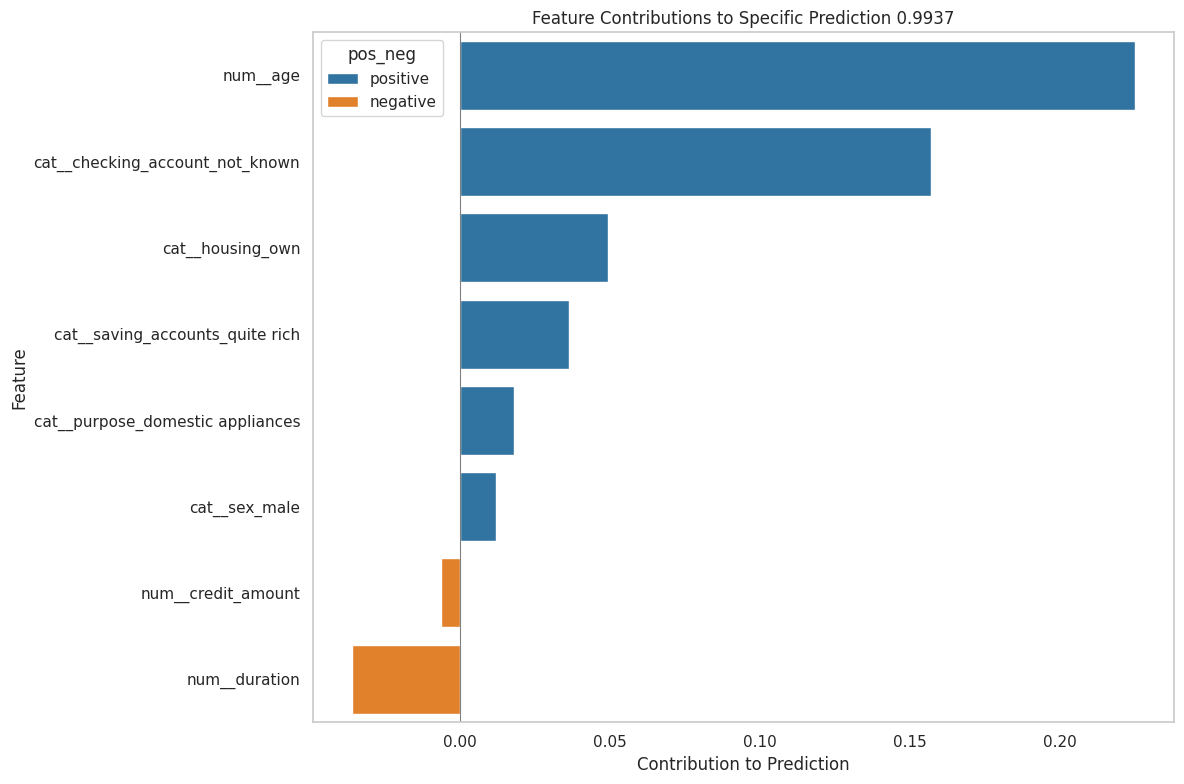

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pred = top_10_tp.loc[0]['prob_default']
# Transform the observation using the preprocessor part of the pipeline
preprocessed_observation = pipeline.named_steps['preprocessor'].transform(observation)

# Flatten the transformed features if it's in a 2D array for a single observation
preprocessed_observation = preprocessed_observation.flatten()

# Get the model's coefficients (assuming your model is named 'model' and it's the last step of the pipeline)
coefficients = pipeline.named_steps['explainer'].coef_.flatten()

# Calculate contributions of each feature
contributions = preprocessed_observation * coefficients

# Since the transformed observation includes encoded categorical variables,
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame
df_contributions = pd.DataFrame({'Feature': feature_names, 'Contribution': contributions})
df_contributions['pos_neg'] = np.where(df_contributions['Contribution'] < 0, 'negative','positive')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=df_contributions.query('Contribution != 0').sort_values('Contribution', ascending=False),
            x="Contribution",
            y='Feature',
            # color='skyblue',
            hue='pos_neg')
plt.xlabel('Contribution to Prediction')
plt.title(f'Feature Contributions to Specific Prediction {pred:.4f}')
plt.axvline(x=0, color='grey', linewidth=0.8)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [ ]:
test_data['prob_default'] = glu_model.predict_proba(test_data)[1]
test_data['pred_default'] = glu_model.predict(test_data)
top_10_fp = test_data.query('risk != pred_default and risk == 0').sort_values(by='prob_default', ascending=False).head(10).reset_index(drop=True)
top_10_fp

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age,prob_default,pred_default
0,0,male,1,own,little,not_known,2538,24,car,47,0.988395,1
1,0,male,2,own,quite rich,not_known,2397,24,radio/TV,35,0.986230,1
2,0,male,1,own,quite rich,moderate,766,12,radio/TV,66,0.980451,1
3,0,male,1,own,little,little,709,12,radio/TV,57,0.969254,1
4,0,female,2,rent,rich,moderate,433,6,education,24,0.967822,1
5,0,male,1,own,little,not_known,1533,18,furniture/equipment,43,0.959510,1
6,0,male,2,own,not_known,little,6350,30,furniture/equipment,31,0.959105,1
7,0,female,3,own,little,not_known,3349,36,furniture/equipment,28,0.954494,1
8,0,male,2,own,rich,moderate,1512,15,repairs,61,0.952523,1
9,0,female,2,own,not_known,not_known,5003,21,car,29,0.934271,1


In [ ]:
test_data['prob_default'] = glu_model.predict_proba(test_data)[1]
test_data['pred_default'] = glu_model.predict(test_data)
top_10_fn = test_data.query('risk != pred_default and risk == 1').sort_values(by='prob_default', ascending=False).head(10).reset_index(drop=True)
top_10_fn

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age,prob_default,pred_default
0,1,female,2,rent,little,not_known,1236,9,domestic appliances,23,0.496254,0
1,1,male,2,own,little,little,2522,30,radio/TV,39,0.484322,0
2,1,female,1,rent,little,not_known,1258,12,furniture/equipment,22,0.456818,0
3,1,male,1,rent,little,little,3021,24,furniture/equipment,24,0.452192,0
4,1,male,2,free,not_known,moderate,6681,48,business,38,0.420029,0
5,1,male,1,rent,little,moderate,276,9,car,22,0.402281,0
6,1,male,2,own,little,not_known,1313,9,furniture/equipment,20,0.357061,0
7,1,female,2,own,little,moderate,1206,9,radio/TV,25,0.353970,0
8,1,female,3,own,little,moderate,4795,36,radio/TV,30,0.298812,0
9,1,male,2,free,little,little,5493,36,car,42,0.289828,0
